In [99]:
import geopandas as gpd
# import osmnx as ox
import censusdata
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
year=2017
state_fips=25

In [50]:
bg=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER{}/BG/tl_{}_{}_bg.zip'.format(year, year, state_fips))
# Convert to WGS84
bg = bg.to_crs("EPSG:4326")

In [51]:
bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,25,027,730401,1,250277304011,Block Group 1,G5030,S,360020,0,+42.3030995,-071.7835260,"POLYGON ((-71.78563 42.30372, -71.78547 42.303..."
1,25,027,730401,4,250277304014,Block Group 4,G5030,S,342080,0,+42.2987661,-071.7733476,"POLYGON ((-71.77701 42.30069, -71.77698 42.300..."
2,25,021,422302,2,250214223022,Block Group 2,G5030,S,345358,0,+42.1865194,-070.9418776,"POLYGON ((-70.94656 42.18471, -70.94641 42.184..."
3,25,009,203100,5,250092031005,Block Group 5,G5030,S,363495,0,+42.4855826,-070.8801839,"POLYGON ((-70.88603 42.48529, -70.88580 42.485..."
4,25,009,217202,4,250092172024,Block Group 4,G5030,S,576115,147631,+42.5500525,-070.9062646,"POLYGON ((-70.91214 42.54773, -70.91190 42.548..."


# Compute example metrics over walkable community

### Load json file which maps BGs to walkable BGs

In [48]:
bg_to_walkable_bg=json.load(open('../outputs/walkable_bg/bg_to_walkable_bg_osrm_{}.json'.format(state_fips)))

### Get and clean the LODES Data

OD Files

In [7]:
import urllib.request as ur
from gzip import GzipFile
import pandas as pd

def get_od_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/od/ma_od_main_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    od = pd.read_csv(f)
    return od

def get_rac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/rac/ma_rac_S000_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    rac = pd.read_csv(f)
    return rac

def get_wac_data(state='ma'):
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/wac/ma_wac_S000_JT00_2017.csv.gz'.format(state)) 
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    wac = pd.read_csv(f)
    return wac

In [8]:
# Origin-Destination (OD) File Structure
# Pos Variable Type Explanation
# 1 w_geocode Char15 Workplace Census Block Code
# 2 h_geocode Char15 Residence Census Block Code
# 3 S000 Num Total number of jobs
# 4 SA01 Num Number of jobs of workers age 29 or younger16
# 5 SA02 Num Number of jobs for workers age 30 to 5416
# 6 SA03 Num Number of jobs for workers age 55 or older16
# 7 SE01 Num Number of jobs with earnings $1250/month or less
# 8 SE02 Num Number of jobs with earnings $1251/month to $3333/month
# 9 SE03 Num Number of jobs with earnings greater than $3333/month
# 10 SI01 Num Number of jobs in Goods Producing industry sectors
# 11 SI02 Num Number of jobs in Trade, Transportation, and Utilities industry sectors
# 12 SI03 Num Number of jobs in All Other Services industry sectors
# 13 createdate Char Date on which data was created, formatted as YYYYMMDD 

In [9]:
od=get_od_data(state='ma')
# block -> block group
od['w_block_group']=od.apply(lambda row: str(row['w_geocode'])[0:12], axis=1)
od['h_block_group']=od.apply(lambda row: str(row['h_geocode'])[0:12], axis=1)
cols_to_sum=['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']


In [10]:
# For easy indexing save two copies of the OD matrix df
od_by_hbg_wbg=od.groupby(['h_block_group', 'w_block_group'] , as_index=True)[cols_to_sum].agg('sum')
od_by_wbg_hbg=od.groupby(['w_block_group', 'h_block_group'] , as_index=True)[cols_to_sum].agg('sum')
# also repeat the work bg as a column for doing a secondary indexing (see below)
od_by_hbg_wbg['w_block_group']=od_by_hbg_wbg.apply(lambda row: row.name[1], axis=1)

In [11]:
od_by_hbg_wbg.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
h_block_group w_block_group                                                   
250010101001  250010101001     30     5    13    12     7    11    12     0   
              250010101002     12     4     4     4     2     7     3     1   
              250010101003     36     3    19    14     7    22     7     0   
              250010101004     62     4    35    23    12    18    32     7   
              250010101005     80    13    35    32    21    37    22     0   

                             SI02  SI03 w_block_group  
h_block_group w_block_group                            
250010101001  250010101001     15    15  250010101001  
              250010101002      1    10  250010101002  
              250010101003      8    28  250010101003  
              250010101004     10    45  250010101004  
              250010101005      8    72  250010101005

In [12]:
od_by_wbg_hbg.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  \
w_block_group h_block_group                                                   
250010101001  250010101001     30     5    13    12     7    11    12     0   
              250010101002     18     3     9     6     3     9     6     0   
              250010101003     35     6    13    16     7    10    18     1   
              250010101004     37     5    25     7     6    19    12     0   
              250010101005     23     1    13     9     7     6    10     0   

                             SI02  SI03  
w_block_group h_block_group              
250010101001  250010101001     15    15  
              250010101002      6    12  
              250010101003     16    18  
              250010101004     19    18  
              250010101005      9    14

RAC and WAC fles

In [16]:
rac=get_rac_data(state='ma')
wac=get_wac_data(state='ma')

#### Both files:
- CA: age groups
- CE: earnings groups
- CNS: NAICS
- CR: race
- CT: ethnicity
- CD: education
- CS: sex
#### Additional in WAC:
- CFA: firm age
- CFA: firm size

In [32]:
rac_cols_to_sum=[col for col in rac.columns if not col in ['h_geocode', 'createdate']]
rac['h_block_group']=rac.apply(lambda row: str(row['h_geocode'])[0:12], axis=1)
rac_bg=rac.groupby('h_block_group', as_index=True)[rac_cols_to_sum].agg('sum')
rac_bg.head()

,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,...,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02
h_block_group,,,,,,,,,,,,,,,,,,,,,
250010101001,374,59,172,143,93,133,148,2,0,0,...,0,9,354,20,32,74,99,110,213,161
250010101002,248,43,126,79,71,83,94,0,0,0,...,1,2,239,9,13,58,59,75,140,108
250010101003,297,46,138,113,67,110,120,0,0,0,...,0,6,277,20,35,71,77,68,171,126
250010101004,302,54,148,100,96,113,93,0,0,0,...,1,4,278,24,27,60,96,65,152,150
250010101005,297,34,162,101,81,106,110,0,0,0,...,0,7,276,21,37,67,82,77,150,147


In [33]:
wac_cols_to_sum=[col for col in wac.columns if not col in ['w_geocode', 'createdate']]
wac['w_block_group']=wac.apply(lambda row: str(row['w_geocode'])[0:12], axis=1)
wac_bg=wac.groupby('w_block_group', as_index=True)[wac_cols_to_sum].agg('sum')
wac_bg.head()

,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,...,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05
w_block_group,,,,,,,,,,,,,,,,,,,,,
250010101001,312,67,152,93,62,132,118,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250010101002,100,22,46,32,22,31,47,3,0,0,...,0,0,0,0,0,0,0,0,0,0
250010101003,253,28,123,102,44,116,93,1,0,0,...,0,0,0,0,0,0,0,0,0,0
250010101004,586,73,296,217,154,232,200,2,0,0,...,0,0,0,0,0,0,0,0,0,0
250010101005,645,98,341,206,165,234,246,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
all_bg_in_rac=set(rac_bg.index)
all_bg_in_wac=set(wac_bg.index)

### Functions to compute metrics for a single GEOID

#### Basic Statistics

In [91]:
def get_residents_columns_rac(bgs_in_community, full_rac, all_bg_in_rac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_rac=[bg for bg in bgs_in_community if bg in all_bg_in_rac]
    if len(bgs_in_rac)>0:
        rac_subset=full_rac.loc[bgs_in_rac]
        sum_rac=rac_subset.sum()
        output_dict['total_pop_rac']=sum_rac['C000']
        output_dict['res_income_u1250_rac']=sum_rac['CE01']
        output_dict['res_income_1251-3333_rac']=sum_rac['CE02']
        output_dict['res_income_3333+_rac']=sum_rac['CE03']
        output_dict['res_age_u29_rac']=sum_rac['CE01']
        output_dict['res_age_30-54_rac']=sum_rac['CE02']
        output_dict['res_age_55+_rac']=sum_rac['CE03']
        output_dict['res_edu_no_highsch']=sum_rac['CD01']
        output_dict['res_edu_highsch']=sum_rac['CD02']
        output_dict['res_edu_some_college']=sum_rac['CD03']
        output_dict['res_edu_bach_or_higher']=sum_rac['CD04']
    else:
        print('No data for this community in RAC file: {}'.format(bgs_in_community))
    return output_dict


In [128]:
def get_workers_columns_wac(bgs_in_community, full_wac, all_bg_in_wac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_wac=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_wac)>0:
        wac_subset=full_wac.loc[bgs_in_wac]
        sum_wac=wac_subset.sum()
        output_dict['total_employ_wac']=sum_wac['C000']
        output_dict['emp_income_u1250_wac']=sum_wac['CE01']
        output_dict['emp_income_1251-3333_wac']=sum_wac['CE02']
        output_dict['emp_income_3333+_wac']=sum_wac['CE03']
        output_dict['emp_age_u29_wac']=sum_wac['CE01']
        output_dict['emp_age_30-54_wac']=sum_wac['CE02']
        output_dict['emp_age_55+_wac']=sum_wac['CE03']
        output_dict['emp_edu_no_highsch']=sum_wac['CD01']
        output_dict['emp_edu_highsch']=sum_wac['CD02']
        output_dict['emp_edu_some_college']=sum_wac['CD03']
        output_dict['emp_edu_bach_or_higher']=sum_wac['CD04']
        output_dict['emp_naics_11']=sum_wac['CNS01']
        output_dict['emp_naics_21']=sum_wac['CNS02']
        output_dict['emp_naics_22']=sum_wac['CNS03']
        output_dict['emp_naics_23']=sum_wac['CNS04']
        output_dict['emp_naics_31-33']=sum_wac['CNS05']
        output_dict['emp_naics_42']=sum_wac['CNS06']
        output_dict['emp_naics_44-45']=sum_wac['CNS07']
        output_dict['emp_naics_48-49']=sum_wac['CNS08']
        output_dict['emp_naics_51']=sum_wac['CNS09']
        output_dict['emp_naics_52']=sum_wac['CNS10']
        output_dict['emp_naics_53']=sum_wac['CNS11']
        output_dict['emp_naics_54']=sum_wac['CNS12']
        output_dict['emp_naics_55']=sum_wac['CNS13']
        output_dict['emp_naics_56']=sum_wac['CNS14']
        output_dict['emp_naics_61']=sum_wac['CNS15']
        output_dict['emp_naics_62']=sum_wac['CNS16']
        output_dict['emp_naics_71']=sum_wac['CNS17']
        output_dict['emp_naics_72']=sum_wac['CNS18']
        output_dict['emp_naics_81']=sum_wac['CNS19']
        output_dict['emp_naics_92']=sum_wac['CNS20']
        output_dict['emp_prv_firm_size_u19']=sum_wac['CFS01']
        output_dict['emp_prv_firm_size_20-49']=sum_wac['CFS02']
        output_dict['emp_prv_firm_size_50-249']=sum_wac['CFS03']
        output_dict['emp_prv_firm_size_250-499']=sum_wac['CFS04']
        output_dict['emp_prv_firm_size_500+']=sum_wac['CFS05']
        output_dict['emp_prv_firm_age_0-1']=sum_wac['CFA01']
        output_dict['emp_prv_firm_age_2-3']=sum_wac['CFA02']
        output_dict['emp_prv_firm_age_4-5']=sum_wac['CFA03']
        output_dict['emp_prv_firm_age_6-10']=sum_wac['CFA04']
        output_dict['emp_prv_firm_age_11+']=sum_wac['CFA05']
    else:
        print('No data for this community in WAC file: {}'.format(bgs_in_community))
    return output_dict

In [153]:
def get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac):
    output_dict={}
    bgs_in_od=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_od)>0:
        live_community=od_by_hbg_wbg.loc[bgs_in_od]
        live_work_community=live_community.loc[live_community['w_block_group'].isin(bgs_in_community)]
        sum_live_work_community=live_work_community.sum()
        output_dict['total_live_and_work_od']=sum_live_work_community['S000']
    else:
        print('No data for this community in OD file: {}'.format(bgs_in_community))
    return output_dict  

In [156]:
def get_lodes_stats(row):
    geoid=row['GEOID']
    bgs_in_community=bg_to_walkable_bg[geoid]
#     print('{}: {}'.format(geoid, bgs_in_community))
    wac_outputs=get_workers_columns_wac(bgs_in_community, full_wac=wac_bg, all_bg_in_wac=all_bg_in_wac)
    rac_outputs=get_residents_columns_rac(bgs_in_community, full_rac=rac_bg, all_bg_in_rac=all_bg_in_rac)
#     od_outputs=get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac=all_bg_in_rac)
    for var in rac_outputs:
        row[var]=rac_outputs[var]
    for var in wac_outputs:
        row[var]=wac_outputs[var]
#     for var in od_outputs:
#         row[var]=od_outputs[var]
    return row

In [157]:
bg=bg.apply(lambda row: get_lodes_stats(row), axis=1)

No data for this community in WAC file: ['250259901010']
No data for this community in RAC file: ['250259901010']
No data for this community in WAC file: ['250239900030']
No data for this community in RAC file: ['250239900030']
No data for this community in WAC file: ['250056171015']
No data for this community in RAC file: ['250056171015']
No data for this community in WAC file: ['250199900000']
No data for this community in RAC file: ['250199900000']
No data for this community in WAC file: ['250019900000']
No data for this community in RAC file: ['250019900000']
No data for this community in WAC file: ['250158219032']
No data for this community in RAC file: ['250138113021']
No data for this community in WAC file: ['250079900000']
No data for this community in RAC file: ['250079900000']
No data for this community in WAC file: ['250259801011']
No data for this community in WAC file: ['250059900000']
No data for this community in RAC file: ['250059900000']
No data for this community in W

In [ ]:
bg.head()

### Live-Work Balance Score

In [158]:
def get_live_work_score(row):
    if row['total_pop_rac'] > row['total_employ_wac']:
        return row['total_employ_wac']/row['total_pop_rac']
    else:
        return row['total_pop_rac']/row['total_employ_wac']
    
# TODO- fix function to get live_work data before the below function
def get_live_work_jaccard_score(row):
    return None

In [133]:
bg['live_work_score']=bg.apply(lambda row: get_live_work_score(row), axis=1)

Text(0.5, 1.0, 'Live-Work Score')

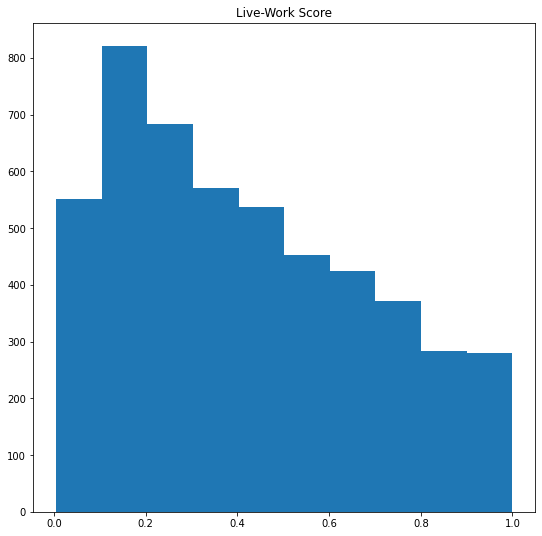

In [159]:
plt.figure(figsize=(9,9))
_=plt.hist(bg['live_work_score'])
plt.title('Live-Work Score')

<AxesSubplot:>

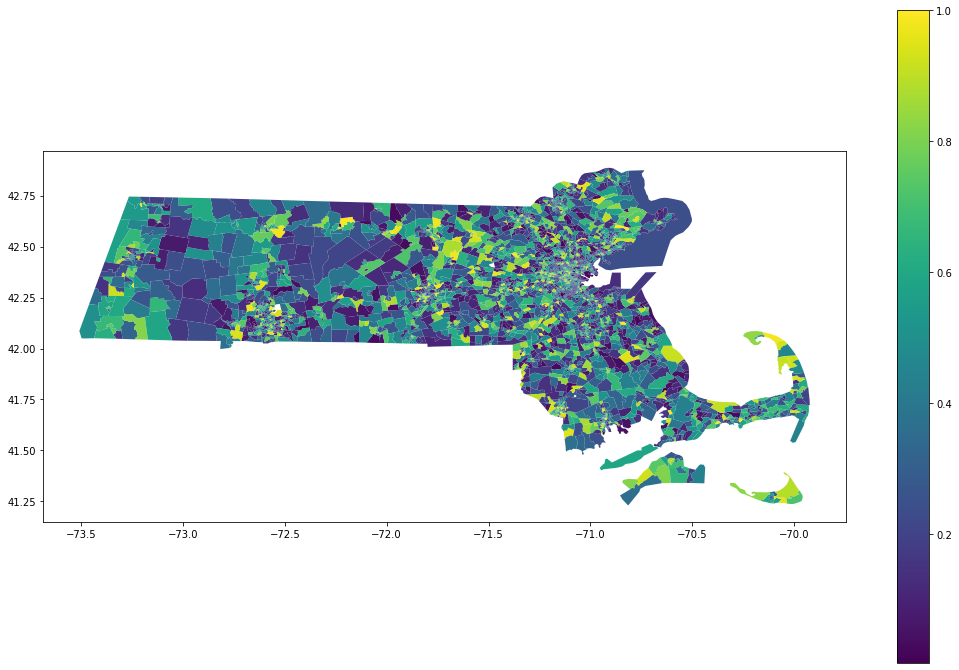

In [166]:
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='live_work_score',
        legend=True)

### Demographic Harmony Scores

In [141]:
from numpy import dot
from numpy.linalg import norm

def get_income_harmony(row):
    res_income_vec=row.loc[['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']]
    emp_income_vec=row.loc[['emp_income_1251-3333_wac', 'emp_income_3333+_wac', 'emp_income_u1250_wac']]
    a, b = res_income_vec.values, emp_income_vec.values
    return dot(a,b)/(norm(a)*norm(b))  

def get_edu_harmony(row):
    res_edu_vec=row[['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']]
    emp_edu_vec=row[['emp_edu_no_highsch', 'emp_edu_highsch', 'emp_edu_some_college', 'emp_edu_bach_or_higher']]
    a, b = res_edu_vec.values, emp_edu_vec.values
    return dot(a,b)/(norm(a)*norm(b)) 

In [143]:
# for col in bg.columns:
#     if 'edu' in col:
#         print(col)

In [142]:
bg['income_harmony']=bg.apply(lambda row: get_income_harmony(row), axis=1)
bg['edu_harmony']=bg.apply(lambda row: get_edu_harmony(row), axis=1)

<ipython-input-141-e59151ec7764>:14: RuntimeWarning: invalid value encountered in double_scalars
  return dot(a,b)/(norm(a)*norm(b))


Text(0.5, 1.0, 'Income Harmony')

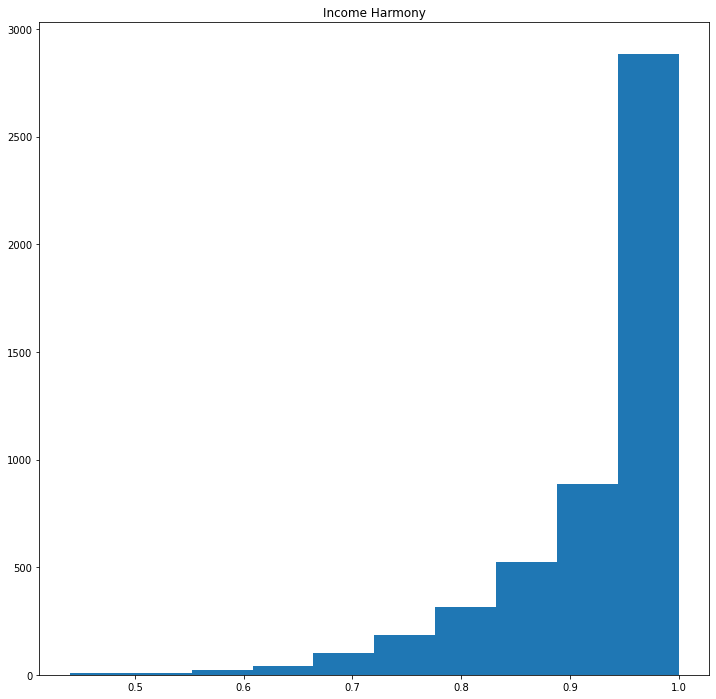

In [144]:
plt.figure(figsize=(12,12))
_=plt.hist(bg['income_harmony'])
plt.title('Income Harmony')

<AxesSubplot:>

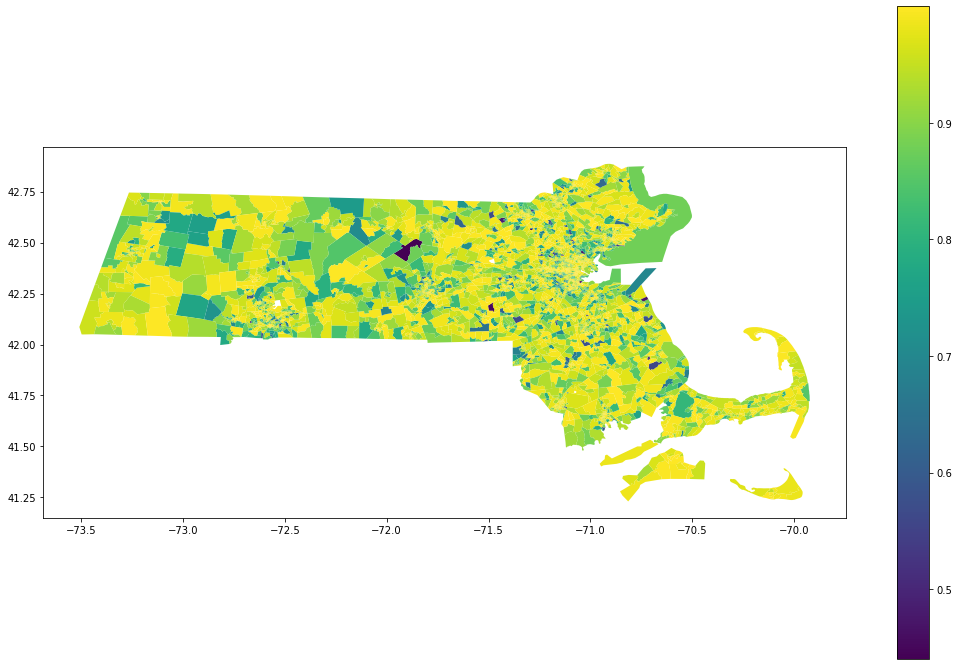

In [165]:
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='income_harmony',
        legend=True)

Text(0.5, 1.0, 'Education Harmony')

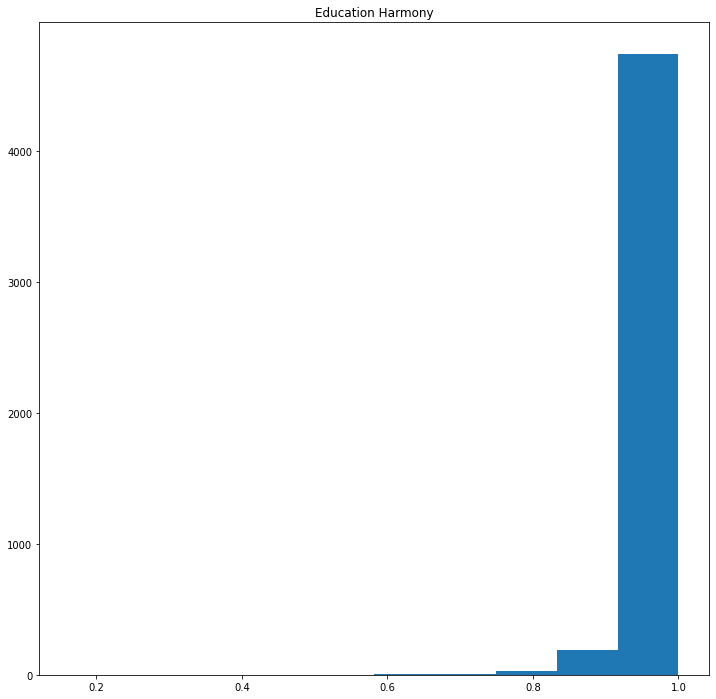

In [145]:
plt.figure(figsize=(12,12))
_=plt.hist(bg['edu_harmony'])
plt.title('Education Harmony')

<AxesSubplot:>

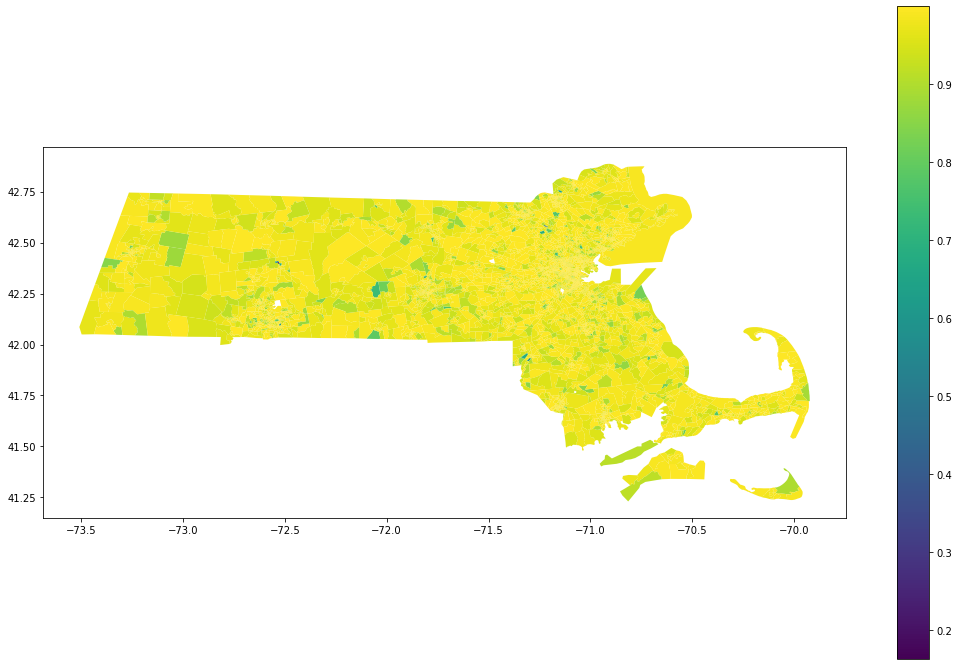

In [164]:
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='edu_harmony',
        legend=True)